## Problem :  PhishShield: Real-time Phishing URL Detector

### 🔹 Machine Learning Solution Steps 

1. Collect Dataset** – Gather phishing and legitimate URLs from public repositories and custom generation.
2. Preprocess Data** – Clean URLs, handle missing values, and normalize text where needed.
3. Feature Extraction** – Convert raw URLs into numeric features (length, digits, subdomains, keywords, TLD, HTTPS, etc.).
4. Feature Engineering** – Add advanced attributes like entropy, domain age, presence of IP address, and special characters.
5. Dataset Splitting** – Divide into training and testing sets (e.g., 80% train, 20% test).
6. Model Selection** – Train multiple classifiers (Decision Tree, Random Forest, XGBoost, SVM) to compare performance.
7. Model Training** – Fit models on the training set using extracted features.
8. Model Evaluation** – Measure accuracy, precision, recall, F1-score, and confusion matrix on the test set.
9. Best Model Choice** – Select the model with the highest balanced performance (e.g., Random Forest / XGBoost).
10. Prediction** – Use the trained model to classify unseen URLs as Phishing (1) or Legitimate (0) in real time.








**1. Importing the dependencies**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.parse import urlparse
import re

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib


**2 .We are convert URLs into numeric features (like length, number of digits, suspicious words, etc.)**

In [2]:

def extract_features(url):
    try:
        parsed = urlparse(url)
    except:
        parsed = urlparse("")
    
    features = {}
    features['url_length'] = len(url)
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['num_digits'] = sum(c.isdigit() for c in url)
    
    # Protocol (https)
    features['https'] = 1 if parsed.scheme == "https" else 0
    
    # Subdomains
    features['num_subdomains'] = parsed.netloc.count('.') - 1
    
    # Keyword presence
    keywords = ['login','secure','account','update','bank','verify','free','paypal']
    features['keywords_count'] = sum(1 for kw in keywords if kw in url.lower())
    
    # Length of domain (host)
    features['domain_length'] = len(parsed.netloc)
    
    # Whether an IP address is used instead of a domain
    features['has_ip'] = 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', parsed.netloc) else 0
    
    # Count of special characters
    specials = ['@', '?', '=', '&', '%', '$']
    features['special_char_count'] = sum(url.count(ch) for ch in specials)
    
    # Presence of suspicious TLD
    suspicious_tlds = ['xyz','top','tk','ml','cf','gq']
    features['suspicious_tld'] = 1 if any(parsed.netloc.endswith(tld) for tld in suspicious_tlds) else 0
    
    # URL path length
    features['path_length'] = len(parsed.path)
    
    return features


**3 . Data Loading and Understanding**

In [3]:
df = pd.read_csv("phishshield_urls_with_type.csv")

In [4]:
df.head()


,url,url_length,count_digits,count_special,has_ip,num_subdomains,is_https,url_entropy,contains_suspicious_word,domain_length,domain_age_days,tld,label,url_type
0,https://13baj.net/F2AB8zO=GGugYv,32,4,6,0,0,1,4.6403,0.0,9.0,476.0,net,0,Legitimate
1,http://b4switqrnjoq.xyz/3,25,2,5,0,0,0,4.1835,0.0,16.0,54.0,xyz,0,Legitimate
2,http://edgs6faxc6y.org/PPi,26,2,5,0,0,0,4.2099,0.0,15.0,39.0,org,0,Legitimate
3,http://secure.7z55hpqlogin.com/cJ&ZSE_ITl?nOD5...,63,6,11,0,1,0,5.2507,1.0,23.0,25.0,com,1,Phishing
4,https://188.181.168.193/f,25,12,7,1,2,1,3.3991,0.0,15.0,276.0,193,1,Phishing


In [5]:
df.shape


(5000, 14)

In [6]:
df.columns


Index(['url', 'url_length', 'count_digits', 'count_special', 'has_ip',
       'num_subdomains', 'is_https', 'url_entropy', 'contains_suspicious_word',
       'domain_length', 'domain_age_days', 'tld', 'label', 'url_type'],
      dtype='object')

**4. Find null values and its Graph**

In [7]:
df.isnull().sum()

url                           0
url_length                    0
count_digits                  0
count_special                 0
has_ip                        0
num_subdomains                0
is_https                      0
url_entropy                 353
contains_suspicious_word    344
domain_length               343
domain_age_days             344
tld                           0
label                         0
url_type                      0
dtype: int64

<Axes: >

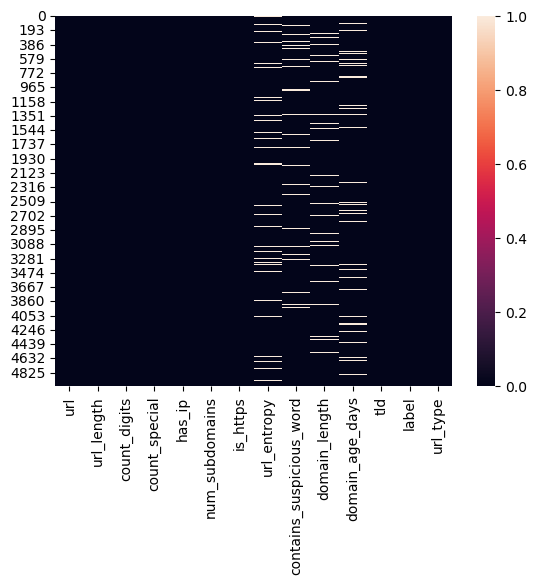

In [8]:
sns.heatmap(df.isnull())


**4. Fil the null value**

In [9]:
df['url_entropy'] = df["url_entropy"].fillna(df["url_entropy"].mode()[0])


In [10]:
df['contains_suspicious_word'] = df["contains_suspicious_word"].fillna(df["contains_suspicious_word"].mode()[0])


In [11]:
df['domain_length'] = df["domain_length"].fillna(df["domain_length"].mode()[0])



In [12]:
df['domain_age_days'] = df["url_entropy"].fillna(df["domain_age_days"].mode()[0])


In [13]:
df.isnull().sum()

url                         0
url_length                  0
count_digits                0
count_special               0
has_ip                      0
num_subdomains              0
is_https                    0
url_entropy                 0
contains_suspicious_word    0
domain_length               0
domain_age_days             0
tld                         0
label                       0
url_type                    0
dtype: int64

**5.Converts extracted feature dictionaries into a dataframe & Convert categorical labels into numbers**


In [14]:
X = pd.DataFrame([extract_features(u) for u in df['url']])

le = LabelEncoder()
y = le.fit_transform(df['url_type'])

print("Feature shape:", X.shape)
X.head()

Feature shape: (5000, 12)


,url_length,num_dots,num_hyphens,num_digits,https,num_subdomains,keywords_count,domain_length,has_ip,special_char_count,suspicious_tld,path_length
0,32,1,0,4,1,0,0,9,0,1,0,15
1,25,1,0,2,0,0,0,16,0,0,1,2
2,26,1,0,2,0,0,0,15,0,0,0,4
3,63,2,0,6,0,1,2,23,0,3,0,11
4,25,3,0,12,1,2,0,15,1,0,0,2


**6. Numerical Features - Analysis**

In [15]:
def plot_histogram(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  # calculate the mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

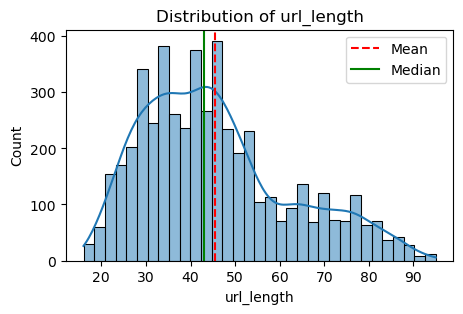

In [16]:
plot_histogram(df, "url_length")

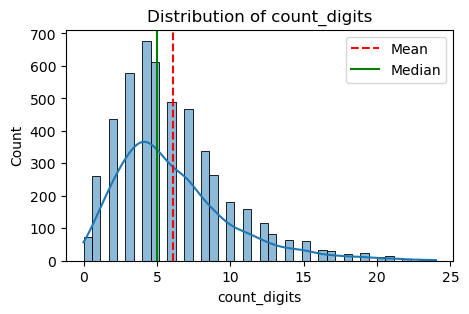

In [17]:
plot_histogram(df, "count_digits")

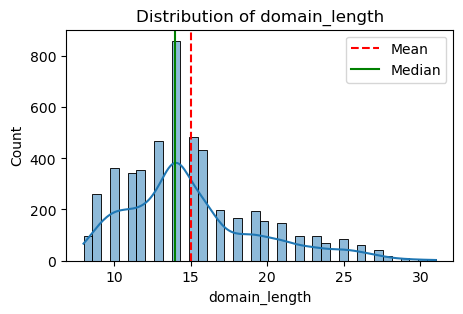

In [18]:
plot_histogram(df, "domain_length")

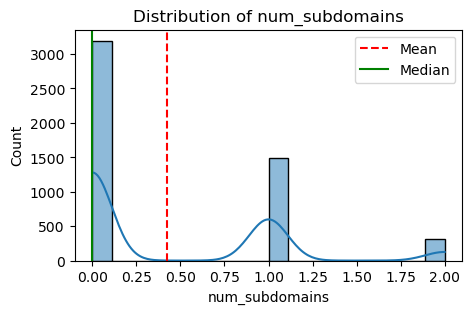

In [19]:
plot_histogram(df,"num_subdomains")

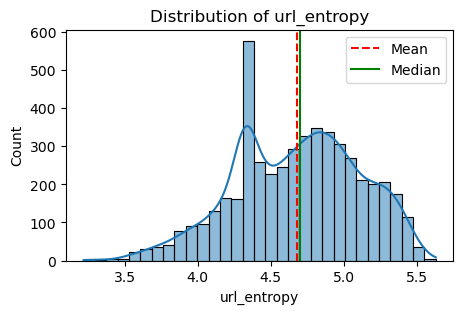

In [20]:
plot_histogram(df,"url_entropy")

**7. Box plot for numerical features**

In [21]:
def plot_boxplot(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.boxplot(y=df[column_name])
  plt.title(f"Box Plot of {column_name}")
  plt.ylabel(column_name)
  plt.show

<Axes: xlabel='url_length'>

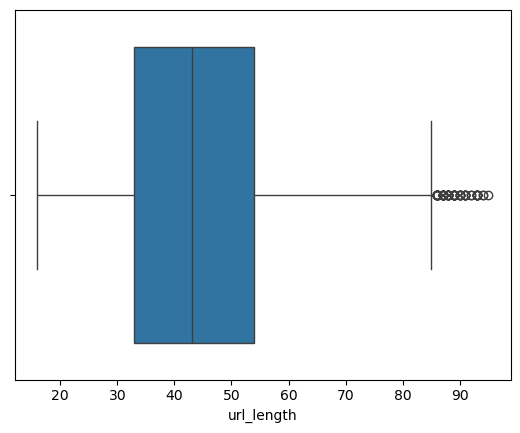

In [22]:

sns.boxplot(x=df["url_length"])


<Axes: xlabel='count_digits'>

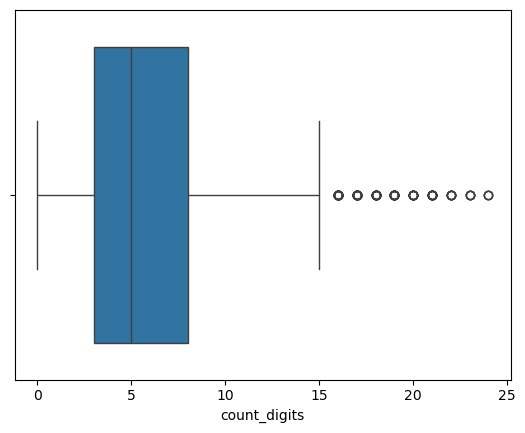

In [23]:
sns.boxplot(x=df["count_digits"])

<Axes: xlabel='num_subdomains'>

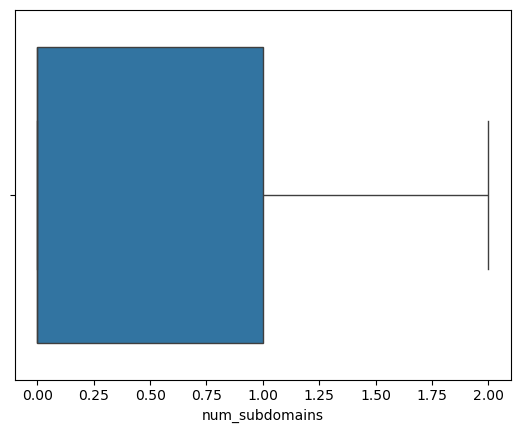

In [24]:
sns.boxplot(x=df["num_subdomains"])

<Axes: xlabel='url_entropy'>

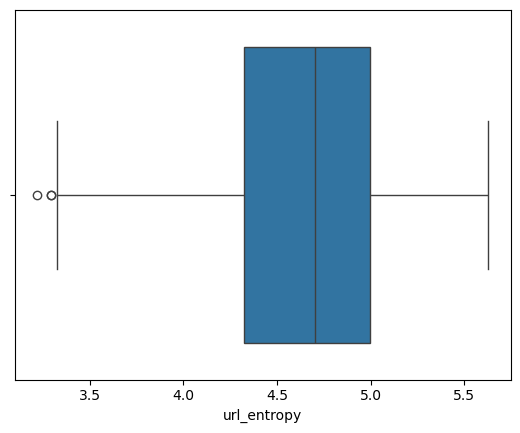

In [25]:
sns.boxplot(x=df["url_entropy"])

<Axes: xlabel='domain_length'>

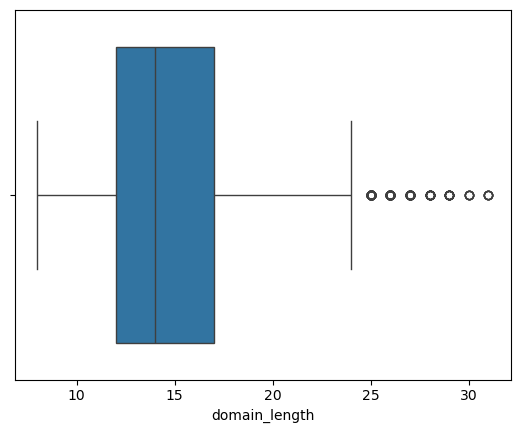

In [26]:
sns.boxplot(x=df["domain_length"])

**8. Train our data and split them into train and test**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=50, stratify=y
)

# Balance with SMOTE
sm = SMOTE(random_state=50)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_bal))


Before SMOTE: [2231 1769]
After SMOTE: [2231 2231]


**9. they represent baseline, ensemble, and boosting approaches**


In [28]:
dt = DecisionTreeClassifier(random_state=50)
rf = RandomForestClassifier(random_state=50, n_jobs=-1)
xgb = XGBClassifier(random_state=50, eval_metric="logloss", n_jobs=-1)

models = {"DecisionTree": dt, "RandomForest": rf, "XGBoost": xgb}

# Cross-validation baseline
for name, model in models.items():
    scores = cross_val_score(model, X_train_bal, y_train_bal, cv=5, scoring="accuracy")
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")


DecisionTree: 0.8254 ± 0.0032
RandomForest: 0.8698 ± 0.0086
XGBoost: 0.8727 ± 0.0100


**10. Hyperparameter tuning for our RandomForestClassifier**

In [29]:
param_dist = {
    "n_estimators": [200, 300, 400],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=10, cv=5, scoring="accuracy", random_state=42, n_jobs=-1
)

search.fit(X_train_bal, y_train_bal)
best_model = search.best_estimator_

print("Best Params:", search.best_params_)


Best Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


**11. Model Performance: Accuracy, Classification Report & Confusion Matrix**

Accuracy: 0.89

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       558
           1       0.93      0.82      0.87       442

    accuracy                           0.89      1000
   macro avg       0.90      0.88      0.89      1000
weighted avg       0.89      0.89      0.89      1000



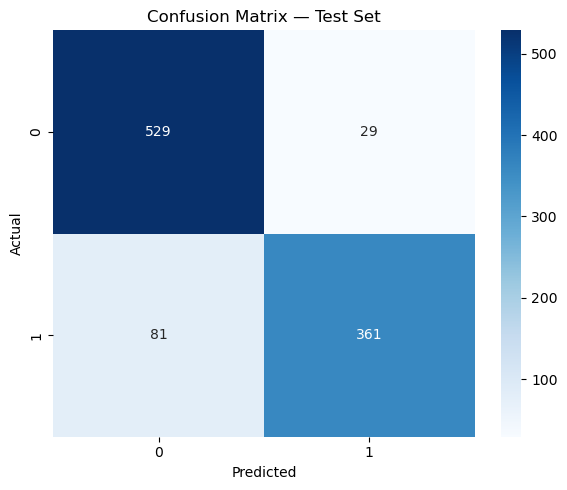

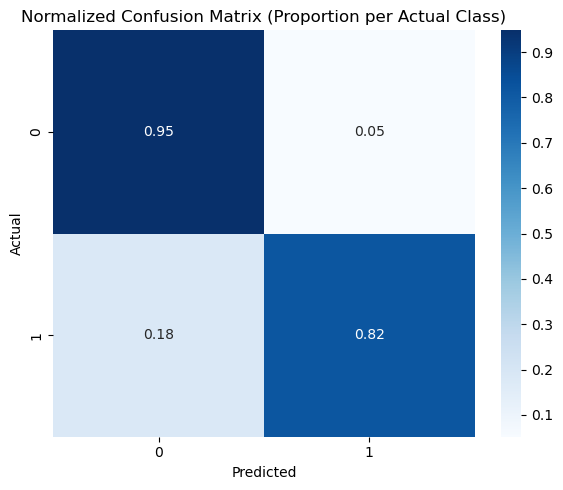

In [30]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix (counts)
cm = confusion_matrix(y_test, y_pred)
class_names = best_model.classes_  # or a list like ['legit','phish']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# Normalized confusion matrix (rows normalized)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (Proportion per Actual Class)")
plt.tight_layout()
plt.show()

**12. Save our trained moder & label encoder & features**

In [31]:
joblib.dump(best_model, "url_phishshield.joblib")
joblib.dump(le, "label_encoder.joblib")
joblib.dump(list(X.columns), "feature_names.joblib")

print("✅ Model and artifacts saved")


✅ Model and artifacts saved


**13. Load our model then write  predict function then  predict the url**

In [32]:
# Load model
model = joblib.load("url_phishshield.joblib")
encoder = joblib.load("label_encoder.joblib")
feature_names = joblib.load("feature_names.joblib")

def predict_url(url):
    feats = pd.DataFrame([extract_features(url)])[feature_names]
    pred = model.predict(feats)[0]
    return encoder.inverse_transform([pred])[0]

# Test
print(predict_url("https://u92waeuik0m8.uk/eht9R0uXxfWj7	"))
print(predict_url("http://sugeyyc.co/c5YOfejx"))


Legitimate
Legitimate
